In [14]:
import os, datetime, nltk

from collections import OrderedDict, defaultdict, Counter
from ipywidgets import IntProgress
from IPython.display import display
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Use the index from *Compilers: Principles, Techniques, and Tools* to compare with our automatically generated index.

In [2]:
DATA_DIR = '../../data/'
with open(DATA_DIR + 'dragon_index.txt') as f:
    dragon_index = set(line.strip() for line in f)

Read and parse .srt closed-caption files. Break them into "documents" by time.

In [3]:
FMT = '%H:%M:%S,%f'

def srt_to_strs(f, interval_length):
    '''Convert a .srt file to a dict of strings'''
    
    # [(text, start_time, end_time)]
    intervals = []
    while True:
        _seq_no = f.readline().strip()
        if _seq_no == '': break
        start_str, end_str = f.readline().strip().split(' --> ')
        start_time = datetime.datetime.strptime(start_str, FMT)
        end_time = datetime.datetime.strptime(end_str, FMT)
        
        text_lines = []
        while True:
            text_line = f.readline().strip()
            if text_line == '': break
            text_line = text_line.replace('&#39;', '')
            text_line = text_line.replace('&gt;', '')
            text_lines.append(text_line)
            
        text = ' '.join(text_lines)
        intervals.append((text, start_time, end_time))
        
    _text, interval_start_time, _end_time = intervals[0]
    
    result = OrderedDict()
    lecture_name = os.path.basename(f.name)[:-4]
    interval_lines = []
    for idx, (text, start_time, end_time) in enumerate(intervals):
        interval_lines.append(text)
        
        if idx == len(intervals) - 1 or end_time - interval_start_time > interval_length:
            result[(lecture_name, interval_start_time, end_time)] = ' '.join(interval_lines)
            interval_start_time = end_time
            interval_lines = []
            
    return result

CAPTIONS_DIR = DATA_DIR + 'compilers_captions/'
SRT_FILE_NAMES = [CAPTIONS_DIR + file_name for file_name in os.listdir(CAPTIONS_DIR) if file_name.endswith('.srt')]

documents = OrderedDict()
for name in SRT_FILE_NAMES:
    with open(name) as f:
        documents.update(srt_to_strs(f, datetime.timedelta(minutes=10)))

POS tag the closed caption files, and store the words that occur for each part of speech.

In [4]:
raw = ' '.join(documents.values())
sents = [nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(raw)]
tags = []

prog = IntProgress(min=0, max=len(sents))
display(prog)

for sent in sents:
    try:
        tags.append(nltk.pos_tag(sent))
    except UnicodeDecodeError:
        pass
    
    prog.value += 1

pos_to_tokens = defaultdict(set)
for sent in tags:
    for token, pos in sent:
        pos_to_tokens[pos].add(token.lower())

In [5]:
VALID_TAGS = [
    'NN', # noun, common, singular or mass
    'NNP', # noun, proper, singular
    'NNPS', # noun, proper, plural
    'NNS', # noun, common, plural
    'JJ', # adjective or numeral, ordinal
    'JJR', # adjective, comparative
    'JJS' # adjective, superlative
]

valid_tokens = set()
for pos in VALID_TAGS:
    valid_tokens = valid_tokens.union(pos_to_tokens[pos])
    
# Filter out tokens like 'abstract abstract'
no_repeats = lambda string: Counter(string.split()).most_common()[0][1] == 1

# Don't keep tokens like 'abstract' or 'abstract syntax tree' if there is another token 'abstract syntax tree'
unique_substring = lambda vocabulary: lambda string: not any([string in other for other in vocabulary - set([string])])

# Take strings that have any valid token.
has_valid = lambda string: any([token in valid_tokens for token in string.split()])

Lemmatize the closed caption files and remove stop words.

In [8]:
# http://www.ranks.nl/stopwords
with open(DATA_DIR + 'ranks_nl_stop_words_long.txt') as f:
    stop_words = [line.strip().replace("'", '') for line in f]
# A few added stop words
stop_words.extend(['thing', 'things', 'hello',  'going',  'uh',  'gonna',  'jack',  'will',  'alright', 'cuz', 'a0', 'a1', 'e0', 'e1', 'e2', 'forgot', 'graduate', 'hope', 'r1', 's1', 's2', 't0', 't1', 't2', 'x1', 'a2i', 'en', 'bs', 'idea', 'keep', 'sa', 'gon', 'eventually', 'excuse'])

# A few removed stop words
stop_words.remove('first')

lemmatizer = nltk.WordNetLemmatizer()
lemmatized_docs = OrderedDict()

prog = IntProgress(min=0, max=len(documents))
display(prog)

for key, doc in documents.items():
    tokens = nltk.word_tokenize(doc)
    lemmatized_tokens = []
    for token in tokens:
        if token not in stop_words:
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token))
            except:
                pass
            
    lemmatized_docs[key] = ' '.join(lemmatized_tokens)
    
    prog.value += 1

pprint(documents.values()[0][:100])   
pprint(lemmatized_docs.values()[0][:100])

'Welcome to this course on compilers. My name is Alex Aiken. Im a professor here at Stanford Universi'
u'Welcome course compiler . My Alex Aiken . Im professor Stanford University . And talking implementat'


Clean up the index entries.

In [9]:
def normalize_entry(entry):
    return entry.lower().replace('-', ' ').replace(',', '').replace('(','').replace(')','')

normalized_dragon_index = set(map(normalize_entry, dragon_index))

Run TFIDF and sort words by the sum of all the TFIDF values (i.e. sum across all documents so `len(sums) = len(tfidf.vocabulary_)`. Then choose the vocabulary size that maximizes the Jaccard score. Plot Jaccard score vs. index size.

433

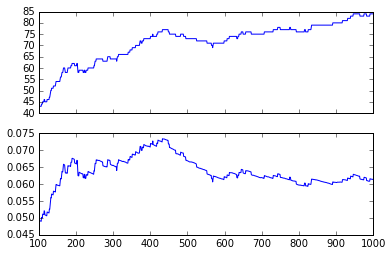

In [32]:
tfidf = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1,4),
    max_df=40
)

X = tfidf.fit_transform(lemmatized_docs.values())
sums = np.array(X.sum(axis=0)).flatten()
sorted_inds = np.argsort(sums)
inverse_voc = np.array([k for k, v in sorted(tfidf.vocabulary_.items(), key=lambda (k, v): v)])

intersection_sizes = []
jaccard_scores = []
sizes = np.linspace(100, 1000, num=1000 - 100 + 1, dtype=int)
prog = IntProgress(min=0, max=len(sizes))
display(prog)
for size in sizes:
    auto_index = set(filter(has_valid, inverse_voc[sorted_inds[-size:]]))
    auto_index = set(filter(no_repeats, auto_index))
    auto_index = set(filter(unique_substring(auto_index), auto_index))
    intersection_size = len(auto_index.intersection(normalized_dragon_index))
    intersection_sizes.append(intersection_size)
    jaccard_scores.append(float(intersection_size) / len(auto_index.union(normalized_dragon_index)))
    prog.value += 1

f, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
axes[0].plot(sizes, intersection_sizes)
_ = axes[1].plot(sizes, jaccard_scores)
sizes[np.argmax(jaccard_scores)]

In [33]:
best_index = set(filter(has_valid, inverse_voc[sorted_inds[-433:]]))
best_index = set(filter(no_repeats, best_index))
best_index = set(filter(unique_substring(best_index), best_index))

Find the intersection, false positives (i.e. included in the generated index and not the Dragon index), and false positives.

In [34]:
intersection = normalized_dragon_index.intersection(best_index)
print len(intersection)
pprint(intersection)

77
set([u'abstract syntax tree',
     u'activation record',
     u'alphabet',
     u'architecture',
     u'array',
     u'attribute',
     u'basic block',
     u'body',
     u'branch',
     u'cache',
     u'child',
     u'code generation',
     u'coloring',
     u'compile time',
     u'configuration',
     u'conflict',
     u'constant',
     u'context free grammar',
     u'declaration',
     u'derivation',
     u'dfa',
     u'edge',
     u'empty string',
     u'epsilon',
     u'field',
     u'final state',
     u'finite automaton',
     u'fortran',
     u'function call',
     u'garbage collection',
     u'handle',
     u'heap',
     u'identifier',
     u'inheritance',
     u'initialization',
     u'intermediate code',
     u'item',
     u'java',
     u'jump',
     u'keyword',
     u'loop',
     u'nfa',
     u'node',
     u'nonterminal',
     u'optimization',
     u'parameter',
     u'parse tree',
     u'parser',
     u'pass',
     u'path',
     u'phase',
     u'predecessor',
     u'pre

In [35]:
false_negatives = normalized_dragon_index - best_index
print len(false_negatives)
pprint(false_negatives)

750
set(['acceptance',
     'accepting state',
     'access link',
     'action',
     'activation tree',
     'actual parameter',
     'acyclic call string',
     'acyclic path',
     'acyclic test',
     'ada',
     'address',
     'address descriptor',
     'address space',
     'advancing edge',
     'affine array access',
     'affine expression',
     'affine partitioning',
     'affine space partition',
     'affine transformation',
     'aho corasick algorithm',
     'algebraic identities',
     'alias',
     'alignment',
     'allocation of memory',
     'alpha',
     'ambiguous grammar',
     "amdahl's law",
     'analysis',
     'ancestor',
     'annotated parse tree',
     'anticipated expression',
     'antidependence',
     'antisymmetry',
     'antlr',
     'arithmetic expression',
     'array contraction',
     'ascii',
     'assembler',
     'assembly language',
     'associativity',
     'atom',
     'attribute grammar',
     'augmented grammar',
     'auto increment'

In [36]:
possible_false_negatives = set([word for word in false_negatives if word in tfidf.vocabulary_])
negatives_to_sums = {k: sums[tfidf.vocabulary_[k]] for k in possible_false_negatives}
print len(possible_false_negatives)
pprint(negatives_to_sums)

184
{'acceptance': 0.034917049165285,
 'accepting state': 0.27094391598201373,
 'action': 0.20079001901492879,
 'activation tree': 0.081560880340095468,
 'actual parameter': 0.10184241332802371,
 'address': 1.1820644534420826,
 'alias': 0.020560045574283148,
 'alignment': 0.20001658319652663,
 'alpha': 1.5894568411970211,
 'ambiguous grammar': 0.083104090685025001,
 'analysis': 1.1795018561417503,
 'ancestor': 0.15857844405429375,
 'arithmetic expression': 0.088194559982370913,
 'ascii': 0.022481050238957977,
 'assembly language': 0.2610702033211455,
 'augmented grammar': 0.01952468265030163,
 'automaton': 1.590629513525301,
 'bison': 0.060724223316817046,
 'block': 1.3888527141789011,
 'bytecode': 0.17664299777081241,
 'call string': 0.079294395903881404,
 'calling sequence': 0.1173074993163587,
 'chunk': 0.039420893150062752,
 'clock': 0.015058189518036027,
 'closure': 0.23373069115526421,
 'code optimization': 0.02967156070692294,
 'coercion': 0.26525873499442248,
 'comment': 0.0223

In [37]:
false_positives = best_index - normalized_dragon_index
print len(false_positives)
pprint(false_positives)

222
set([u'accepting',
     u'accumulator',
     u'actual',
     u'addition',
     u'algorithm',
     u'allocate',
     u'allocation',
     u'alternative',
     u'application',
     u'argument type',
     u'assembly',
     u'assignment',
     u'assumption',
     u'bar',
     u'beta',
     u'better',
     u'big',
     u'blank',
     u'bottom parsing',
     u'boundary',
     u'build',
     u'bunch',
     u'byte',
     u'calling',
     u'cast',
     u'catch',
     u'change',
     u'character',
     u'clearly',
     u'close paren',
     u'common',
     u'complete',
     u'complicated',
     u'compute',
     u'consistent',
     u'consists',
     u'construct',
     u'content',
     u'continue',
     u'control flow graph',
     u'cool',
     u'copy',
     u'correct',
     u'cost',
     u'current',
     u'cycle',
     u'data',
     u'dead',
     u'decide',
     u'decision',
     u'declared',
     u'define',
     u'design',
     u'detail',
     u'deterministic',
     u'digit',
     u'discussion

Write out the index.

In [38]:
with open(DATA_DIR + 'auto_index.txt', 'w') as f:
    for string in sorted(best_index):
        count = len([k for k, v in lemmatized_docs.items() if string in v])
        f.write('{}\n'.format(string, count))

Lookup the minutes where "abstract syntax tree" and "recursive descent" appear.

In [50]:
print('recursive descent' in auto_index)

keys = sorted([key for key, doc in lemmatized_docs.items() if 'recursive descent' in doc])
pprint(['{}: {} --> {}'.format(key[0], key[1], key[2]) for key in keys])

True
['06-03-recursive-descent-parsing: 1900-01-01 00:00:03.949000 --> 1900-01-01 00:06:32.020000',
 '06-04-1-recursive-descent-limitations-04-1: 1900-01-01 00:00:00.560000 --> 1900-01-01 00:06:55.809000',
 '06-04-recursive-descent-algorithm: 1900-01-01 00:00:04.150000 --> 1900-01-01 00:10:05.350000',
 '07-01-Predictive-Parsing-Part-1: 1900-01-01 00:00:03.780000 --> 1900-01-01 00:07:36.340000',
 '07-05-Bottom-Up-Parsing-Part-1: 1900-01-01 00:00:03.860000 --> 1900-01-01 00:07:04.080000',
 '09-03-symbol-tables: 1900-01-01 00:00:03.530000 --> 1900-01-01 00:10:05.600000',
 '12-02-A+Code+Generation+I: 1900-01-01 00:10:07.150000 --> 1900-01-01 00:14:32.890000']


In [51]:
print('abstract syntax tree' in auto_index)

keys = sorted([key for key, doc in lemmatized_docs.items() if 'abstract syntax tree' in doc])
pprint(['{}: {} --> {}'.format(key[0], key[1], key[2]) for key in keys])

True
['06-02-abstract-syntax-trees: 1900-01-01 00:00:04.799000 --> 1900-01-01 00:03:48.260000',
 '09-03-symbol-tables: 1900-01-01 00:00:03.530000 --> 1900-01-01 00:10:05.600000',
 '09-04-types: 1900-01-01 00:10:06.610000 --> 1900-01-01 00:11:20.920000',
 '09-09-implementing-type-checking: 1900-01-01 00:00:05.150000 --> 1900-01-01 00:06:53.740000',
 '10-06-error-recovery: 1900-01-01 00:00:04.059000 --> 1900-01-01 00:07:04.240000',
 '12-02-A+Code+Generation+I: 1900-01-01 00:10:07.150000 --> 1900-01-01 00:14:32.890000',
 '14-02-optimization-overview: 1900-01-01 00:00:03.730000 --> 1900-01-01 00:10:07.370000']
